<a href="https://colab.research.google.com/github/simrathanspal/deep_models_from_scratch/blob/main/word2vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
corpus = [
    "The king is a strong and wise ruler.",
    "The queen is a wise and powerful monarch.",
    "A man must be strong to be a king.",
    "A woman can be a powerful monarch.",
    "The ruler of the kingdom is either a king or a queen.",
    "He is the king and she is the queen.",
]

# Two word2vec architectures

Shallow 2 layer network
2 layers because two sets of learnable parameters

1.   input -> hidden
2.   hidden -> output



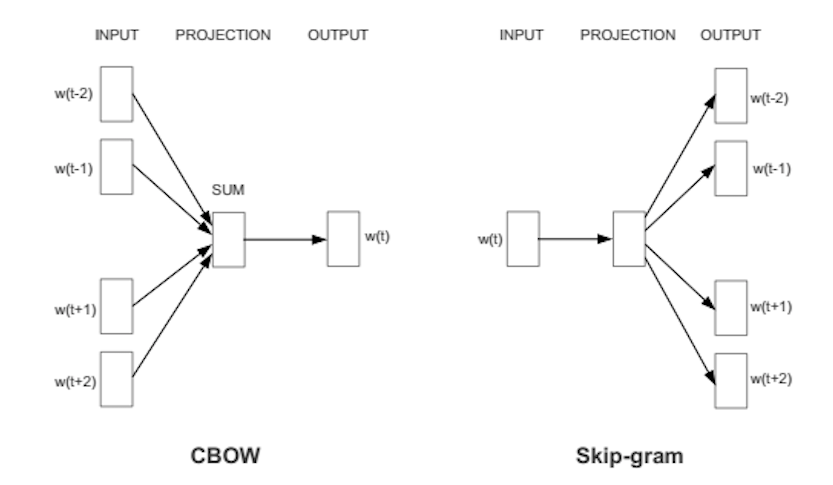

## Skip Gram - predict the surrounding context

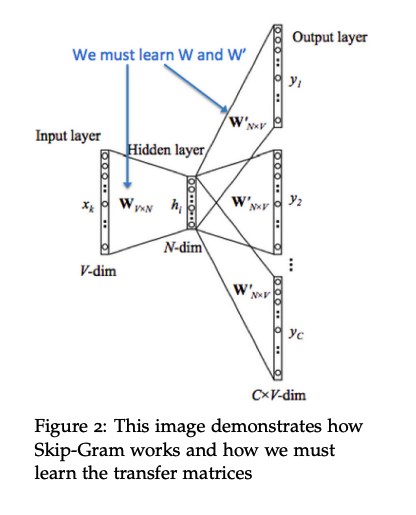

In the skip gram model we are training bunch of target and context token pairs

Consider the sentence `"The quick brown fox jumped over the dog"`

If target word is `jumped` then we create pairs like

`(jumped, brown), (jumped, fox), (jumped, over), (jumped, the)`

We dont care about the position here, all we care about is teaching the model the associations and updating the target embedding.

In my view this is a confusing training setup as one word has to predict always different words. But as a training task I think it is a good setup because it avoids overfitting and forces the model to generalise well.

Especially important as the complexity of the task is not much - just predicting the next word.

In [ ]:
import numpy as np

vocab = sorted(np.unique(np.concatenate([c.split() for c in corpus])))
word_to_index = {word: index for index, word in enumerate(vocab)}
index_to_word = {index: word for index, word in enumerate(vocab)}


def one_hot_vec(index, size):
  vec = np.zeros(size)
  vec[index] = 1
  return vec

In [ ]:
def generate_skip_gram_data(window_size=1):
  training_data = []
  for index, word in enumerate(vocab):
    target_word = word
    target_index = index
    context = []
    for j in range(max(0,index-window_size) , min(len(vocab), index+window_size+1)):
      if index == j:
        continue
      context.append(j)
      training_data.append([target_index, context])
    return training_data



In [ ]:
# Model parameters
hidden_dim = 5
learning_rate = 0.01
epochs = 25 # Number of times the model sees whole data

# Weight initialisation
# Random value from -1 (inclusive) to 1 (exclusive)
W1 = np.random.uniform(-1, 1, (len(vocab), hidden_dim))
W2 = np.random.uniform(-1, 1, (hidden_dim, len(vocab)))

In [ ]:
training_data_skip = generate_skip_gram_data()
print(training_data_skip[0])


# ---- Training loop ----
for epoch in range(epochs):
  total_loss = 0
  for target_idx, context in training_data_skip:
    # 1. Get one hot vector for target word
    x = one_hot_vec(target_idx, len(vocab))

    # 2. Get the embedding
    h = W1.T@x

    # 3. Score for all context words
    u = W2.T@h

    # 4. Calculate probabilities
    y_pred = np.exp(u)/np.sum(np.exp(u))


    # --- Calculate loss --- #
    loss = -np.log(y_pred[context])
    total_loss += loss

    # ---- Backward pass ---- #

    # Explanation
    #
    # Consider we have bunch of neuron weight going to output neuron.
    # We want to now distribute the Loss at output neuron to all the previous neurons.
    # For this we need to understand what is the contribution of every previous neuron to the loss.
    #
    # dLoss/dW = (dLoss/dOutput).(dOutput/dW)
    # Change in Loss for a small change in weights =
    # (Change in Loss for a small change in Output) x (Change in Output for a small change in weights)
    # dOutput/dwi = d(w0X0 + w1x1 + ...wiXi+... )/dwi
    # When taking a derivative for wi, all the other weights are treated as constant and derivative will be 0
    # Hence dOutput/dwi = Xi (same as activation at last layer and input at the first layer) or h in our case
    #
    # Now we need to compute (dL/dOutput)
    # Loss = cross entropy of softmax
    # Output = softmax of logits
    # First we take softmax (y_pred) = e^(logit_i)/ sum of all logit exponentials
    # Next we take cross entropy = - Sum of all classes [ y_true.log(y_pred) ]
    # derivative of cross entropy = y_pred - y_actual
    # Note the derivative of other loss function need not be y_pred - y_loss hence we can't simiplify like this

    # 1. calculate error
    # error is difference between predicted and expected probabilities
    e = y_pred.copy()
    # y_pred - y_act
    # 0.85 - 1 => -0.15 => Gives the direction that prob is low
    # 0.85 - 0 => 0.85 => Gives the direction that prob is high
    # Hence we need to subtract -1 only for target class
    e[context] -= 1

    # 2. Calculate the gradient for W2
    grad_W2 = np.outer(h, e)

    # 3. Calculate the gradient for W1
    # Distributing the error back is slightly unintuitive but we can understand this with an analogy
    # Imagine that hidden layer is a water source and from this water source the water is flowing to
    # final destination. Every neuron connection can be thought of as a channel.
    # The width of the channel defines how much water flows through it and this is what our weights are
    # controlling - how much information flows.
    # Now when we want to back propogate the error we need to send it through the same channel
    # Hence the error reaching the previous layer is distributed by the weight
    grad_W1 = np.outer(x, W2@e)

    # --- Update weights --- #
    W1 -= learning_rate * grad_W1
    W2 -= learning_rate * grad_W2

  print(f"Epoch: {epoch+1}, Loss: {total_loss}")
print("\n--- Skip-gram Final Embeddings (W1) ---")
print(W1)


[0, [1]]
Epoch: 1, Loss: [3.16077696]
Epoch: 2, Loss: [3.13949396]
Epoch: 3, Loss: [3.11830382]
Epoch: 4, Loss: [3.09719882]
Epoch: 5, Loss: [3.07617139]
Epoch: 6, Loss: [3.05521409]
Epoch: 7, Loss: [3.03431961]
Epoch: 8, Loss: [3.01348081]
Epoch: 9, Loss: [2.99269067]
Epoch: 10, Loss: [2.9719423]
Epoch: 11, Loss: [2.95122895]
Epoch: 12, Loss: [2.930544]
Epoch: 13, Loss: [2.909881]
Epoch: 14, Loss: [2.88923357]
Epoch: 15, Loss: [2.86859553]
Epoch: 16, Loss: [2.84796078]
Epoch: 17, Loss: [2.82732339]
Epoch: 18, Loss: [2.80667754]
Epoch: 19, Loss: [2.78601758]
Epoch: 20, Loss: [2.76533797]
Epoch: 21, Loss: [2.7446333]
Epoch: 22, Loss: [2.72389833]
Epoch: 23, Loss: [2.70312794]
Epoch: 24, Loss: [2.68231716]
Epoch: 25, Loss: [2.66146117]

--- Skip-gram Final Embeddings (W1) ---
[[ 0.28851715 -0.64813757  0.04332735 -0.34791726 -0.02428784]
 [ 0.72012171  0.2938972  -0.23088328  0.20422043 -0.55514119]
 [-0.36430654  0.51394536 -0.08307547 -0.0266425  -0.80368929]
 [ 0.7623768  -0.35309699 

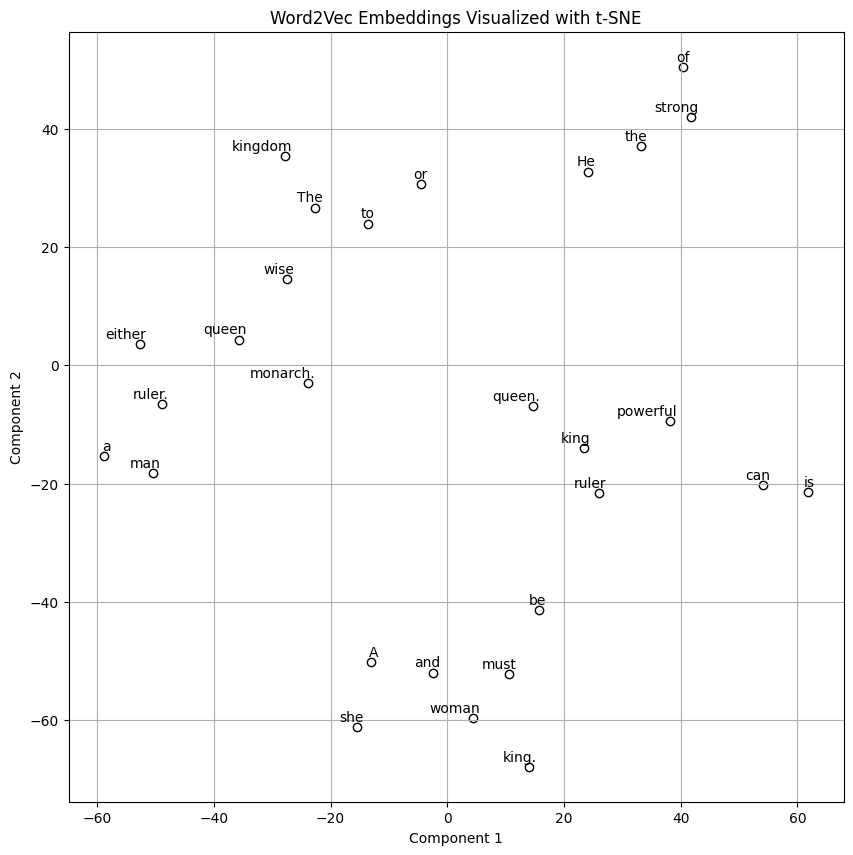

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt


tsne = TSNE(n_components=2, random_state=42, perplexity=5)
vectors_2d = tsne.fit_transform(W1)
plt.figure(figsize=(10, 10))
plt.scatter(vectors_2d[:, 0], vectors_2d[:, 1], edgecolors='k', c='w')

for i, word in enumerate(vocab):
    plt.annotate(word,
                 xy=(vectors_2d[i, 0], vectors_2d[i, 1]),
                 xytext=(5, 2), # Small offset
                 textcoords='offset points',
                 ha='right',
                 va='bottom')

plt.title('Word2Vec Embeddings Visualized with t-SNE')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.grid(True)
plt.show()

# CBOW - Given the surrounding context predict the target

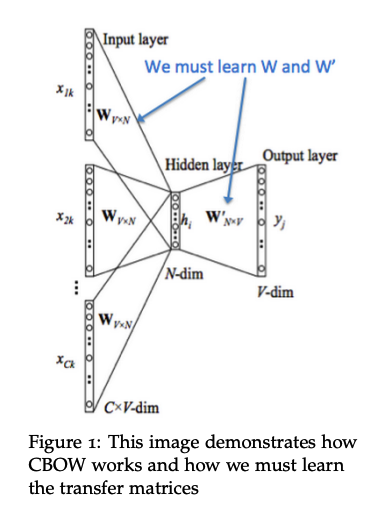

In CBOW we do the opposite of skip gram - here we predict the target

To predict the target we take the context window - `(brown, fox, over, the)`

We take the embeddings of these tokens - average it and then predict `jumped`




In [ ]:
# Major difference

embedding_dim = 5
learning_rate = 0.01
epochs = 25

W1 = np.random.uniform(-1, 1, (len(vocab), embedding_dim))
W2 = np.random.uniform(-1, 1, (embedding_dim, len(vocab)))

# Training data generation
# W1 (vocab, hidden)
# X is one hot encoded hence dimension is len(vocab)
# It can be treated as row vector or column vector. Numpy handles that internally for us

# W1.T@X
# (hidden, vocab)@(vocab, 1)
context_indices = [1,0,1,0,0,1] # Dummy example
context_vectors = W1[context_indices]
h = np.mean(context_vectors, axis=0)

# Here if we want to use previous pattern of W1.T@X, we will need to carefully
# work with the dimensions as we are using multiple words in CBOW
# W1 = (vocab, hidden)
# X = (window, vocab)
# Note both need to be transposed if we want dot product to be possible
# W1.T@X.T
# Filtering is easier code in this example as we need to form X and then compute

u = W2.T @ h
